In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
import os

#import statannotations
from statannot import add_stat_annotation

In [9]:
# Open dfs

ss_2020 = pd.read_csv('../data/img_scout_dfs/2020/skysat_scout_2020.csv')
ss_2021 = pd.read_csv('../data/img_scout_dfs/2021/skysat_scout_2021.csv')
ss_2022 = pd.read_csv('../data/img_scout_dfs/2022/skysat_scout_2022.csv')

skysat_all = pd.concat([ss_2020, ss_2021, ss_2022])
skysat_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 0 to 719
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acquired     2214 non-null   int64  
 1   plot         2214 non-null   int64  
 2   blue         2214 non-null   float64
 3   green        2214 non-null   float64
 4   red          2214 non-null   float64
 5   nir          2214 non-null   float64
 6   row          2214 non-null   int64  
 7   panel        2214 non-null   int64  
 8   Date         2214 non-null   object 
 9   Treatment    2214 non-null   float64
 10  Block        2214 non-null   object 
 11  PM_severity  2214 non-null   float64
 12  DM_severity  2214 non-null   float64
 13  total_dis    2214 non-null   float64
 14  geometry     2214 non-null   object 
 15  centroid     2214 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 294.0+ KB


In [12]:
# Check for duplicates
skysat_dup = skysat_all[skysat_all.duplicated()]
print(skysat_dup)

Empty DataFrame
Columns: [acquired, plot, blue, green, red, nir, row, panel, Date, Treatment, Block, PM_severity, DM_severity, total_dis, geometry, centroid]
Index: []


In [13]:
skysat_all['ndvi']= (skysat_all['nir']-skysat_all['red'])/(skysat_all['nir']+skysat_all['red'])
skysat_all['evi']= 2.5*(skysat_all['nir']-skysat_all['red'])/(skysat_all['nir']+6*skysat_all['red']-7.5*skysat_all['blue']+1)
skysat_all['savi']= 1.5*(skysat_all['nir']-skysat_all['red'])/(skysat_all['nir']+skysat_all['red']+0.5)
skysat_all['sr']= skysat_all['nir']/skysat_all['red']
skysat_all['msr']= ((skysat_all['nir']/skysat_all['red'])-1)/(np.sqrt((skysat_all['nir']/skysat_all['red'])+1))
#skysat_all['dvi']= skysat_all['nir']-skysat_all['red']
#skysat_all['nirv']= skysat_all['ndvi']*skysat_all['nir']
skysat_all['gcc']=skysat_all['green']/(skysat_all['green']+skysat_all['red']+skysat_all['blue'])
#skysat_all['tvi']=0.5*(120*(skysat_all['nir']-skysat_all['green'])-200*(skysat_all['red']-skysat_all['green']))
skysat_all['arvi']=(skysat_all['nir']-(2*skysat_all['red']-skysat_all['blue']))/(skysat_all['nir']+(2*skysat_all['red']-skysat_all['blue']))

skysat_all.head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,total_dis,geometry,centroid,ndvi,evi,savi,sr,msr,gcc,arvi
0,20200625,2,0.055840,0.074537,0.063650,0.284137,1,2,2020-06-25,9.0,...,0.15,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),0.633971,0.441950,0.390110,4.464048,1.481926,0.384157,0.598084
1,20200625,3,0.051873,0.070787,0.058603,0.277567,1,3,2020-06-25,22.0,...,0.10,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),0.651347,0.441410,0.392797,4.736363,1.560022,0.390518,0.618937
2,20200625,4,0.052025,0.073668,0.061257,0.285911,1,4,2020-06-25,18.0,...,0.40,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),0.647104,0.444589,0.397773,4.667386,1.540512,0.394051,0.604437
3,20200625,5,0.047086,0.067566,0.049576,0.312017,1,5,2020-06-25,6.0,...,0.35,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),0.725792,0.522240,0.456900,6.293733,1.960140,0.411414,0.713991
4,20200625,6,0.051490,0.073420,0.058720,0.301683,1,6,2020-06-25,2.0,...,0.00,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453),0.674143,0.479094,0.423575,5.137659,1.670142,0.399826,0.641219


In [14]:
# Add disease class column
skysat_all['disease_class'] = 'low'
skysat_all.loc[skysat_all['DM_severity'] > 10, 'disease_class'] = 'high'

In [15]:
# Get just 2021
ss_2021_dates = ss_2021.Date.unique()
df_2021 = skysat_all[skysat_all['Date'].isin(ss_2021_dates)]
df_2021.shape

(1195, 24)

In [16]:
# Filter to just the downy mildew trial
# This trial was conducted in the first 5 rows only in 2021

dm_trial = df_2021[df_2021['row']<=5]

In [18]:
# Find highest severity 

dm_trial.DM_severity.max()

81.125

In [19]:
# Find lowest severity on the last day

dm_trial[dm_trial['Date']=='2021-08-17']['DM_severity'].min()

0.1

In [20]:
# Print full entry for min. severity panel on the last day

last_day = dm_trial[dm_trial['Date']=='2021-08-17']
last_day[last_day['DM_severity']==0.1]

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,geometry,centroid,ndvi,evi,savi,sr,msr,gcc,arvi,disease_class
1026,20210816,68,0.015376,0.067317,0.04719,0.268572,5,4,2021-08-17,11.0,...,POLYGON ((-77.01553102784763 42.87844998993179...,POINT (-77.01557395530281 42.878462798620625),0.701106,0.385311,0.407072,5.691341,1.813595,0.518292,0.545403,low


In [22]:
# Print entry for highest severity day
dm_trial[dm_trial['DM_severity']==81.125]

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,geometry,centroid,ndvi,evi,savi,sr,msr,gcc,arvi,disease_class
552,20210802,73,0.00703,0.030007,0.029357,0.201513,5,9,2021-08-03,20.0,...,POLYGON ((-77.01596637781898 42.87853151993666...,POINT (-77.01600935030324 42.87854432363066),0.745687,0.324841,0.353325,6.864312,2.091157,0.451953,0.591753,high


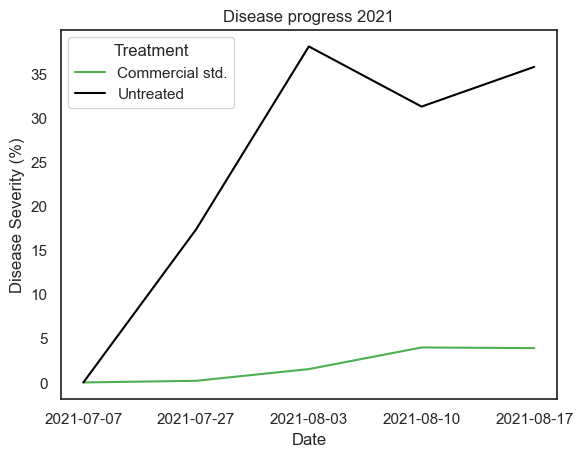

In [25]:
# Plot disease progress for utc and comm. standard
# UTC = untreated control
# comm standard = commercial standard (most effective fungicide)

treats = [11,20]
colors = ["#4CAF50", "#FFFFFF"]
sns.set_theme(style='white')
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.lineplot(data=dm_trial[dm_trial['Treatment'].isin(treats)], x='Date', y= 'DM_severity', hue='Treatment',palette=["#4CAF50", "#000000"], errorbar=None)

plt.xticks
plt.ylabel('Disease Severity (%)')
plt.legend(title='Treatment', loc='upper left', labels=['Commercial std.', 'Untreated'])
plt.title('Disease progress 2021')
plt.savefig('../figs/dis_prog.svg', bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2021-08-03_low v.s. 2021-08-03_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.044e-02 U_stat=9.780e+02
2021-07-27_low v.s. 2021-07-27_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.440e+02
2021-08-10_low v.s. 2021-08-10_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.380e-04 U_stat=1.199e+03
2021-08-17_low v.s. 2021-08-17_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.586e-01 U_stat=9.680e+02


Text(0.5, 1.0, 'ARVI 2021, DM Trial')

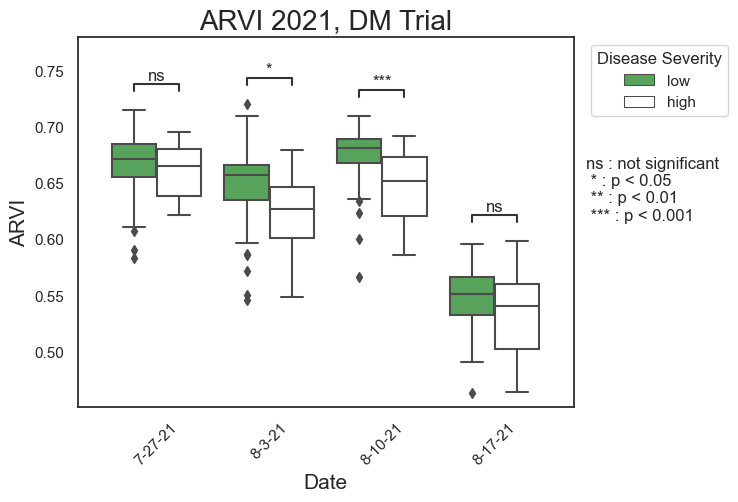

In [26]:
x = "Date"
y = "arvi"
hue = "disease_class"
hue_order=['low', 'high']
order = dm_trial['Date'].unique()[1:]
pairs=[
    ((order[0], "high"), (order[0], "low")),
    ((order[1], "high"), (order[1], "low")),
    ((order[2], "high"), (order[2], "low")),
    ((order[3], "high"), (order[3], "low"))
    ]

colors = ["#4CAF50", "#FFFFFF"]
sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dm_trial, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
ax.set_xticklabels(labels = ['7-27-21','8-3-21','8-10-21','8-17-21'], 
                   rotation=45)
add_stat_annotation(ax, data=dm_trial, x=x, y=y, order=order, hue=hue, box_pairs=pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=15)
plt.ylabel("ARVI", fontsize= 15)
plt.legend(title='Disease Severity',loc='upper left', bbox_to_anchor=(1.02, 1) )
plt.figtext(0.92, 0.5, 'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001', fontsize=12)
plt.title("ARVI 2021, DM Trial", fontsize=20)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2021-08-03_low v.s. 2021-08-03_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.647e-03 U_stat=9.870e+02
2021-07-27_low v.s. 2021-07-27_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.790e-01 U_stat=6.210e+02
2021-08-10_low v.s. 2021-08-10_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.007e-03 U_stat=1.171e+03
2021-08-17_low v.s. 2021-08-17_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.655e-02 U_stat=1.089e+03


Text(0.5, 1.0, 'EVI 2021, DM Trial')

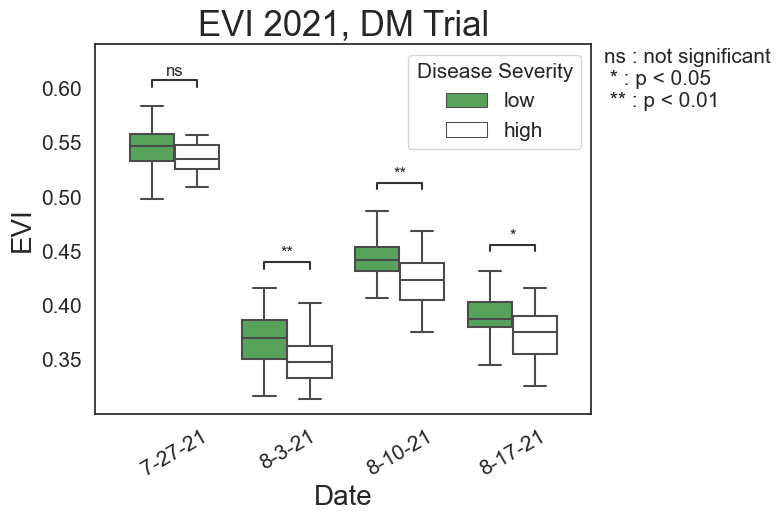

In [28]:
x = "Date"
y = "evi"
hue = "disease_class"
hue_order=['low', 'high']
order = dm_trial['Date'].unique()[1:]
pairs=[
    ((order[0], "high"), (order[0], "low")),
    ((order[1], "high"), (order[1], "low")),
    ((order[2], "high"), (order[2], "low")),
    ((order[3], "high"), (order[3], "low"))
    ]

colors = ["#4CAF50", "#FFFFFF"]
sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dm_trial, x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['7-27-21','8-3-21','8-10-21','8-17-21'], fontsize=15, 
                   rotation=30)

add_stat_annotation(ax, data=dm_trial, x=x, y=y, order=order, hue=hue, box_pairs=pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)

plt.yticks(fontsize=15)
plt.xlabel("Date", fontsize=20)
plt.ylabel("EVI", fontsize= 20)
plt.legend(title='Disease Severity', title_fontsize=15,fontsize=15, loc='upper right', bbox_to_anchor=(1.0, 1) )
plt.figtext(0.92, 0.75, 'ns : not significant\n * : p < 0.05\n ** : p < 0.01', fontsize=15)
plt.title("EVI 2021, DM Trial", fontsize=25)

#plt.savefig('../figs/savi_boxplt.svg', bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2021-08-03_low v.s. 2021-08-03_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.081e-02 U_stat=9.770e+02
2021-07-27_low v.s. 2021-07-27_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.234e-01 U_stat=6.330e+02
2021-08-10_low v.s. 2021-08-10_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.821e-03 U_stat=1.155e+03
2021-08-17_low v.s. 2021-08-17_high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.268e-02 U_stat=1.066e+03


Text(0.5, 1.0, 'SAVI 2021, DM Trial')

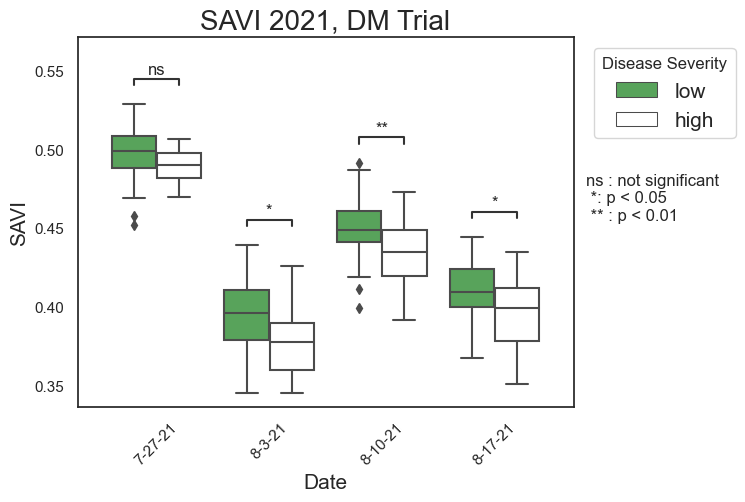

In [29]:
x = "Date"
y = "savi"
hue = "disease_class"
hue_order=['low', 'high']
order = dm_trial['Date'].unique()[1:]
pairs=[
    ((order[0], "high"), (order[0], "low")),
    ((order[1], "high"), (order[1], "low")),
    ((order[2], "high"), (order[2], "low")),
    ((order[3], "high"), (order[3], "low"))
    ]

colors = ["#4CAF50", "#FFFFFF"]
sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dm_trial, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
ax.set_xticklabels(labels = ['7-27-21','8-3-21','8-10-21','8-17-21'], 
                   rotation=45)
add_stat_annotation(ax, data=dm_trial, x=x, y=y, order=order, hue=hue, box_pairs=pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=15)
plt.ylabel("SAVI", fontsize= 15)
plt.legend(title='Disease Severity',fontsize=15, loc='upper left', bbox_to_anchor=(1.02, 1) )
plt.figtext(0.92, 0.5, 'ns : not significant\n *: p < 0.05\n ** : p < 0.01', fontsize=12)
plt.title("SAVI 2021, DM Trial", fontsize=20)

#plt.savefig('savi_boxplt.png', bbox_inches='tight')

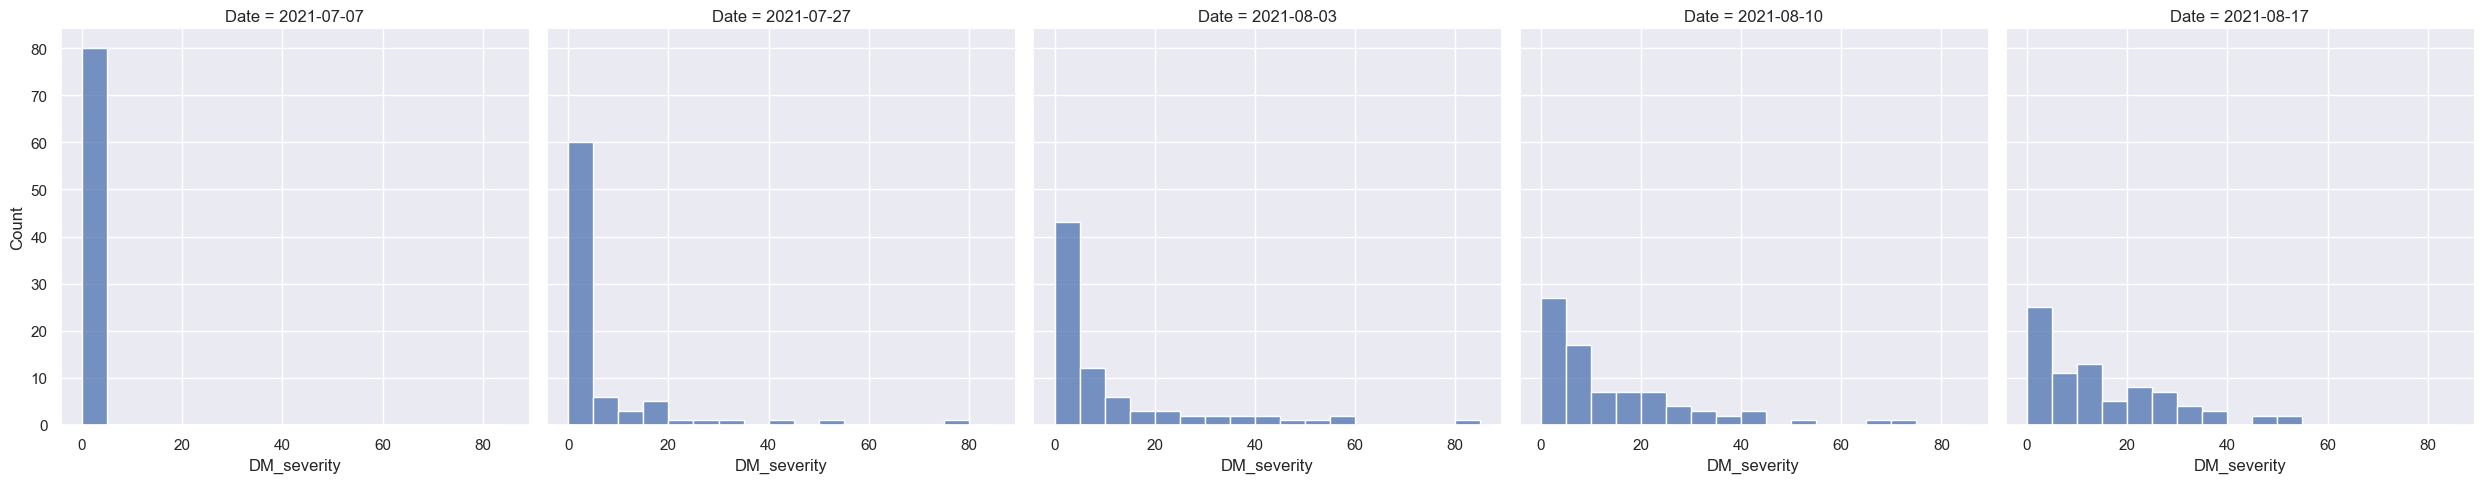

In [30]:
sns.set_theme(style="darkgrid")

sns.displot(
    dm_trial, x="DM_severity", col="Date",
    binwidth=5, height=5) #facet_kws=dict(margin_titles=True),

plt.show()

Text(0.5, 1.0, 'DM Severity by Date, 2021\n DM Trial')

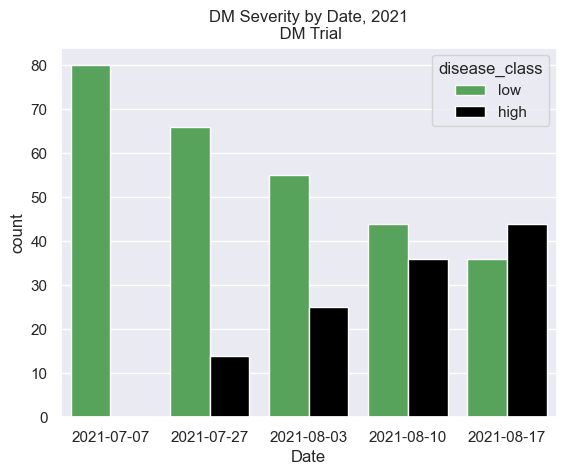

In [32]:
sns.set_theme(style="darkgrid")
colors = ["#4CAF50", "#000000"]
sns.set_palette(sns.color_palette(colors))

sns.countplot(data=dm_trial, x="Date", hue="disease_class")
plt.title('DM Severity by Date, 2021\n DM Trial')

#plt.savefig('..figs/sevbydate_dmtrial.png')

Text(0.5, 1.0, 'DM Severity by Date, 2021\n All Rows')

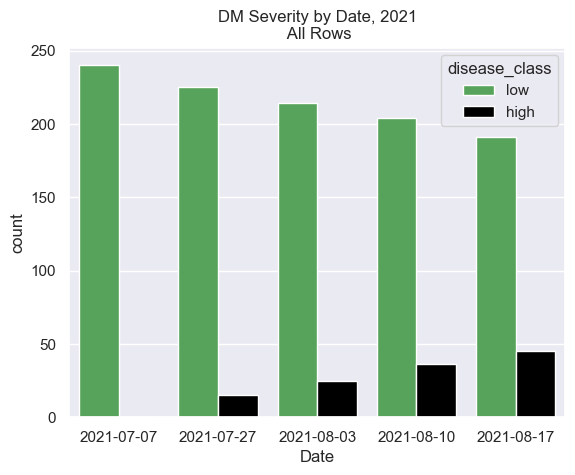

In [33]:
sns.set_theme(style="darkgrid")
colors = ["#4CAF50", "#000000"]
sns.set_palette(sns.color_palette(colors))

sns.countplot(data=df_2021, x="Date", hue="disease_class")
plt.title('DM Severity by Date, 2021\n All Rows')

#plt.savefig('../figs/sevbydate.png')

In [34]:
# Visualize correlations between wavelengths, VIs, and disease

# first filter the df to just these columns

skysat_all.columns.unique()


Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'ndvi', 'evi', 'savi', 'sr', 'msr', 'gcc',
       'arvi', 'disease_class'],
      dtype='object')

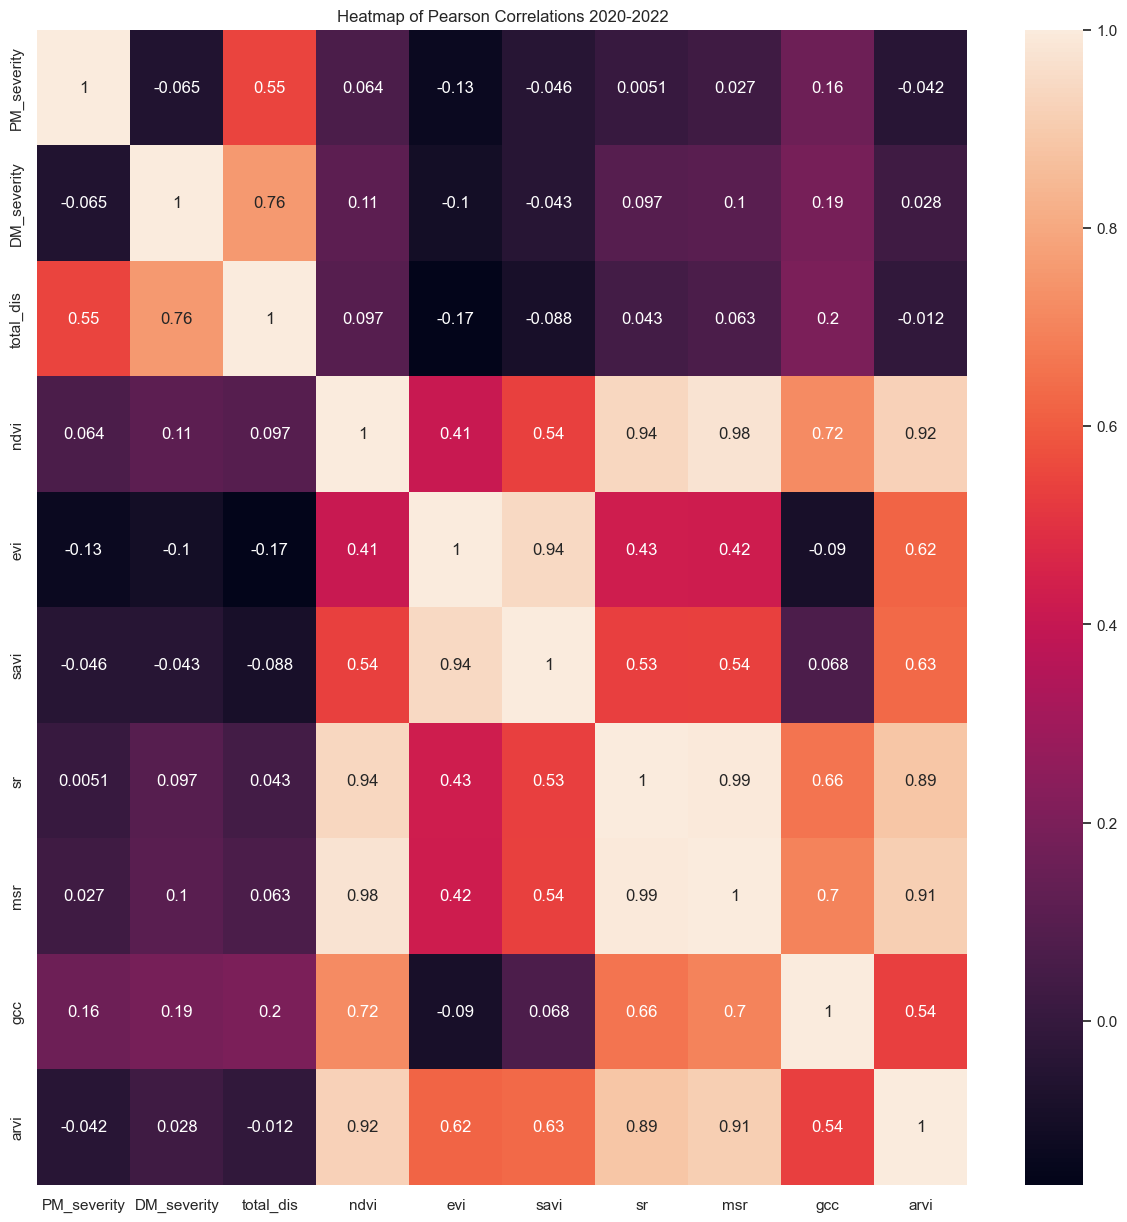

In [35]:
cols = ['PM_severity','DM_severity', 'total_dis', 'ndvi', 'evi', 'savi', 'sr', 'msr', 'gcc', 'arvi']
filtered = skysat_all[cols]
correlations = filtered.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlations, annot=True).set(title='Heatmap of Pearson Correlations 2020-2022');
plt.show()

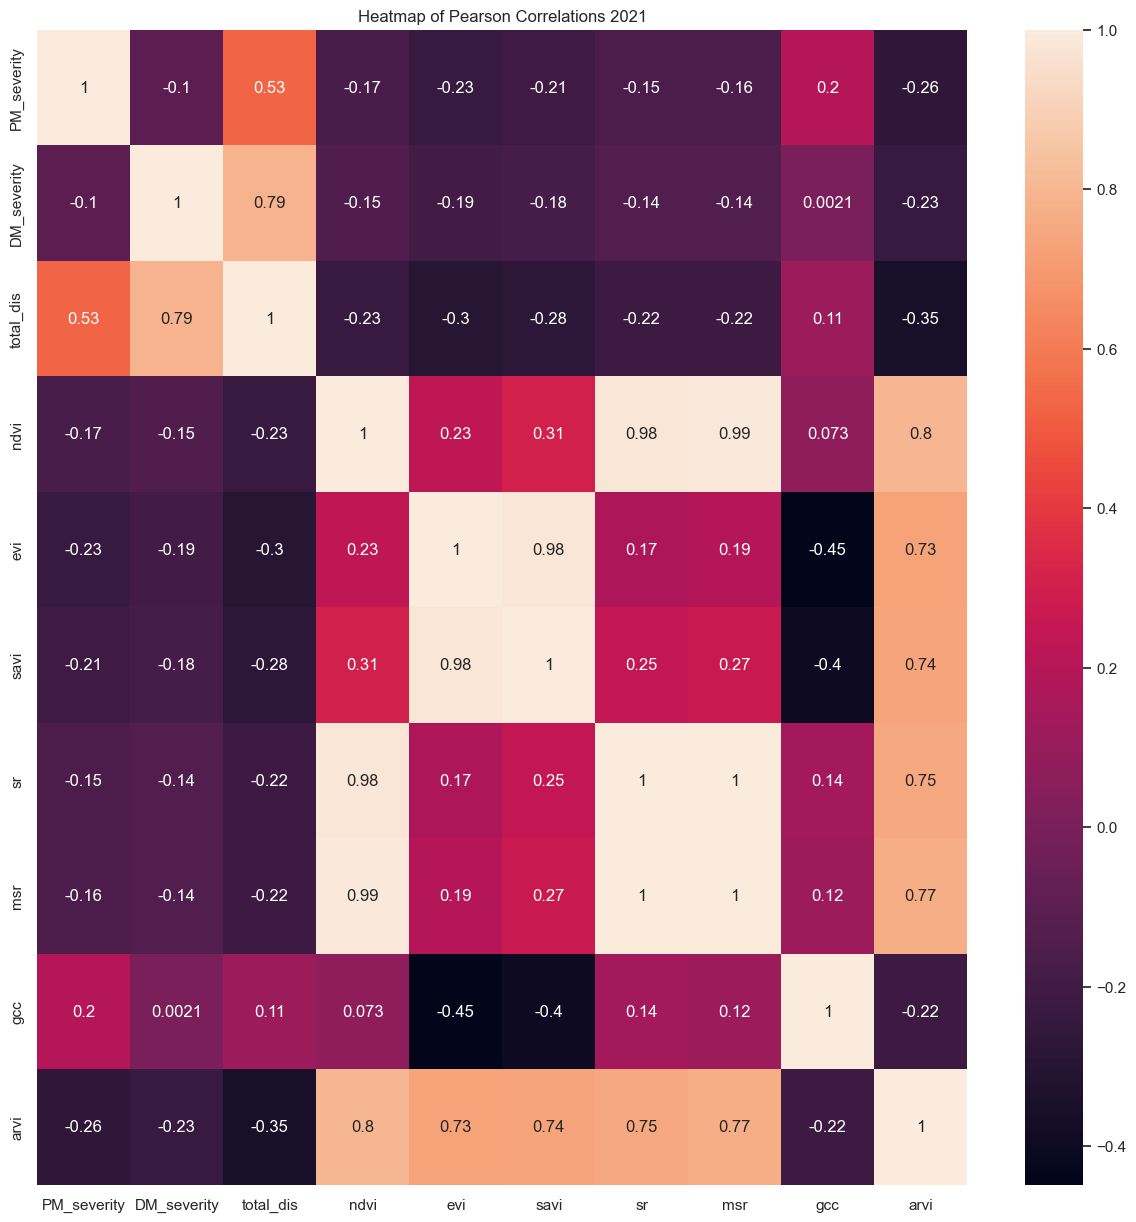

In [36]:
filtered_2021 = df_2021[cols]
correlations_2021 = filtered_2021.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlations_2021, annot=True).set(title='Heatmap of Pearson Correlations 2021');
plt.show()

In [37]:
from scipy.stats import spearmanr

In [38]:
# Check spearman's R for disease vs. EVI in 2021

corr, _ = spearmanr(df_2021['DM_severity'], df_2021['evi'])
print("Spearman's correlation EVI, 2021: %.3f" % corr)
print('p-value: %.3f' %_)

Spearman's correlation EVI, 2021: -0.178
p-value: 0.000


In [39]:
# Check spearman's R for disease vs. ARVI in 2021

corr, _ = spearmanr(df_2021['DM_severity'], df_2021['arvi'])
print("Spearman's correlation ARVI, 2021: %.3f" % corr)
print('p-value: %.3f' %_)

Spearman's correlation ARVI, 2021: -0.304
p-value: 0.000


In [40]:
from scipy import stats
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return print("Mann-Whitney U:", u_statistic, "p-value:", p_value)


#### MAIN FUNCTION ####
#Perform the Mann-Whitney U Test on the two distributions

high_2021 = df_2021[df_2021['disease_class']=='high']
low_2021 = df_2021[df_2021['disease_class']=='low']

In [41]:
mann_whitney_u_test(high_2021['arvi'], low_2021['arvi'])

Mann-Whitney U: 37414.0 p-value: 1.8798564187286408e-14


In [42]:
mann_whitney_u_test(high_2021['savi'], low_2021['savi'])

Mann-Whitney U: 45430.0 p-value: 5.5962957162352214e-08


In [43]:
mann_whitney_u_test(high_2021['evi'], low_2021['evi'])

Mann-Whitney U: 44764.0 p-value: 1.9509066616126387e-08


In [44]:
mann_whitney_u_test(high_2021['ndvi'], low_2021['ndvi'])

Mann-Whitney U: 48678.0 p-value: 5.933512271808268e-06


In [45]:
high_2021.iloc[:, 2:6]

,blue,green,red,nir
257,0.039979,0.076186,0.058634,0.357662
264,0.041257,0.076057,0.054167,0.355180
265,0.041457,0.077332,0.058714,0.357157
273,0.043690,0.078921,0.062028,0.346786
274,0.041176,0.079490,0.061128,0.347045
...,...,...,...,...
1031,0.017131,0.067779,0.051631,0.247683
1032,0.014800,0.065496,0.046896,0.265800
1036,0.009743,0.065223,0.044500,0.261313
1037,0.013334,0.064976,0.045017,0.265424


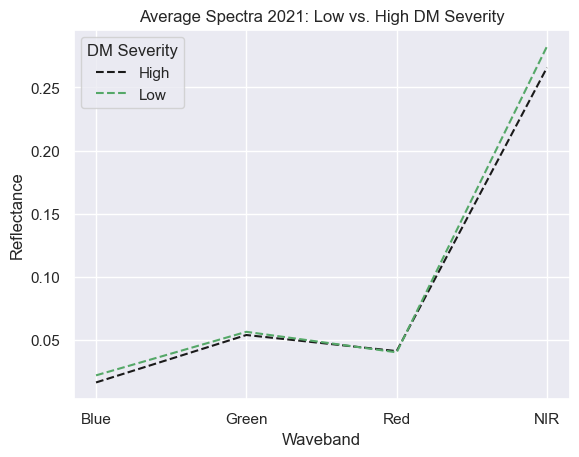

In [46]:
plt.plot(high_2021.iloc[:, 2:6].mean(), '--k', label='High')
plt.plot(low_2021.iloc[:, 2:6].mean(), '--g', label='Low')

plt.xlabel('Waveband')
plt.ylabel('Reflectance')
plt.xticks(np.arange(4), ['Blue', 'Green', 'Red', 'NIR'])
plt.legend(title='DM Severity')
plt.title('Average Spectra 2021: Low vs. High DM Severity')
plt.show()

In [47]:
# Importing library
from scipy.stats import f_oneway

f_oneway(high_2021['arvi'], low_2021['arvi'])

F_onewayResult(statistic=58.883750103284534, pvalue=3.462067830309952e-14)

In [48]:
f_oneway(high_2021['evi'], low_2021['evi'])

F_onewayResult(statistic=36.06989054983817, pvalue=2.5237972385760686e-09)

In [49]:
f_oneway(high_2021['savi'], low_2021['savi'])

F_onewayResult(statistic=30.061090124947423, pvalue=5.1058325860758224e-08)

In [50]:
f_oneway(high_2021['ndvi'], low_2021['ndvi'])

F_onewayResult(statistic=24.291842994272535, pvalue=9.446411105902329e-07)

In [51]:
high_2021.shape

(121, 24)

In [52]:
low_2021.shape

(1074, 24)

In [53]:
dm_high = high_2021[high_2021['row']<=5]
dm_low = low_2021[low_2021['row']<=5]

mann_whitney_u_test(dm_high['arvi'], dm_low['arvi'])

Mann-Whitney U: 7421.0 p-value: 1.418789331476936e-18


In [54]:
mann_whitney_u_test(dm_high['evi'], dm_low['evi'])

Mann-Whitney U: 9043.0 p-value: 3.8280110533687407e-13


In [55]:
mann_whitney_u_test(dm_high['savi'], dm_low['savi'])

Mann-Whitney U: 9402.0 p-value: 4.456493446506538e-12


In [57]:
# Let's try a model
import sklearn

feature_names = ['blue', 'green', 'red', 'nir', 'ndvi', 'evi', 'arvi', 'savi']
X = df_2021[feature_names]
y = df_2021['disease_class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [58]:
print('Training feature size:',X_train.shape[0])
print('Test feature size:',X_test.shape[0])


Training feature size: 896
Test feature size: 299


In [59]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.90
Accuracy of Logistic regression classifier on test set: 0.88


In [60]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[  0  35]
 [  0 264]]


In [61]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.81


In [62]:
predictions_clf = clf.predict(X_test)
score_clf = clf.score(X_test, y_test)
from sklearn import metrics
cm_clf = metrics.confusion_matrix(y_test, predictions_clf)
print(cm_clf)

[[  5  30]
 [ 26 238]]


In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.91
Accuracy of K-NN classifier on test set: 0.88


In [64]:
predictions_knn = knn.predict(X_test)
score_knn = knn.score(X_test, y_test)
from sklearn import metrics
cm_knn = metrics.confusion_matrix(y_test, predictions_knn)
print(cm_knn)

[[  3  32]
 [  5 259]]


In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.90
Accuracy of LDA classifier on test set: 0.88


In [66]:
predictions_lda = lda.predict(X_test)
score_lda = lda.score(X_test, y_test)
from sklearn import metrics
cm_lda = metrics.confusion_matrix(y_test, predictions_lda)
print(cm_lda)

[[  0  35]
 [  1 263]]


In [67]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.78
Accuracy of GNB classifier on test set: 0.78


In [68]:
predictions_gnb = gnb.predict(X_test)
score_gnb = gnb.score(X_test, y_test)
from sklearn import metrics
cm_gnb = metrics.confusion_matrix(y_test, predictions_gnb)
print(cm_gnb)

[[  9  26]
 [ 40 224]]


In [69]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.90
Accuracy of SVM classifier on test set: 0.88


In [70]:
predictions_svm = svm.predict(X_test)
score_svm = svm.score(X_test, y_test)
from sklearn import metrics
cm_svm = metrics.confusion_matrix(y_test, predictions_svm)
print(cm_svm)

[[  0  35]
 [  0 264]]
